## importing required libraries

In [279]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import struct
import numpy as np
import numpy
import random
import tensorflow as tf
import os
import pickle as pickle
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import time
from pathlib import Path
%matplotlib inline

def format_time(t):
    return t.strftime("%Y-%m-%d %H:%M:%S")

#this function helps to visualize the dict
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
# take(1, prod_desc.values())

# load data after creating features
def load_data_hybrid(data_path, min_items=2, min_users=2):
    user_ratings = defaultdict(set)
    item_ratings = defaultdict(set)
    max_u_id = -1
    max_i_id = -1
    user_count = 0
    item_count = 0
    reviews = 0
    users = {}  # aid to id LUT
    items = {}  # asid to id LUT
    records = {} # all records
    features = {}
    random.seed(0)
    columns = None
    offset_to_features = 3
    with open(data_path, 'r') as f:
        bad_actor = 0
        for line in f.readlines():
            record = {}
            split_line = line.split('\t')
            if columns is None:
                columns = [e.rstrip() for e in split_line]
                continue
            #if (sampling and random.random()>sample_size):
            #   continue
            reviews += 1
            
            if (len(split_line) != len(columns)):
                raise Exception ("Line %d isn't aligned. Found %d values on line. In %d column file" 
                                 % (reviews, len(split_line), len(columns)))
                #bad_actor = bad_actor + 1
                #continue
            else:
                auid, asid, _ = split_line[0:offset_to_features]
                record = {columns[i]:split_line[i].rstrip() for i in  range (offset_to_features, len(split_line))}

            u, i = None, None

            if auid in users:
                u = users[auid]
            else:
                user_count += 1  # new user so increment
                users[auid] = user_count
                u = user_count
            
            if asid in items:
                i = items[asid]
            else:
                item_count += 1  # new i so increment
                items[asid] = item_count
                i = item_count
                
                if 'cluster' in record:
                    record['cluster'] = float(record['cluster'])
                
                for c in ['price_delta_calc1','price_delta_calc2','price_delta_l4avg']:
                    if c in record:
                        record[c] = float(record[c])
                if 'price' in record:
                    if record['price'] == '':
                        record['price'] = 0
                    else:
                        record['price'] = float(record['price'])
                if 'level4_average' in record:
                    if record['level4_average'] == '':
                            record['level4_average'] = 0
                    else:
                        record['level4_average'] = float(record['level4_average'])
#                         Price ratio feature added
                        record['level4_ratio_price']= record['price']/record['level4_average']
                if 'polarity' in record:
                    record['polarity']= round((float(record['polarity'])),2)
                    
                if 'feature_vector' in record:
                    if len(record['feature_vector']) == 0:
                        record['feature_vector'] = list(np.zeros(4524))
                    else:
                        record['feature_vector'] = [int(el) for el in list(record['feature_vector'])[:-1][1:]]
    
                for c in ['top_categories','rating','percentile_hotcoded','season','level4','sentiment']:
                    if c in record:
                        record[c] = [int(el) for el in list(record[c])[:-2][1:]]
                records[i] = record
            
            user_ratings[u].add(i)
            item_ratings[i].add(u)
            max_u_id = max(u, max_u_id)
            max_i_id = max(i, max_i_id)
            
    print ("max_u_id: ", max_u_id)
    print ("max_i_id: ", max_i_id)
    print ("reviews : ", reviews)


    # filter out users w/ less than X reviews
    num_u_id = 0
    num_i_id = 0
    num_reviews = 0
    user_ratings_filtered = defaultdict(set)
    for u, ids in user_ratings.items():
        if len(ids) > min_items:
            user_ratings_filtered[u] = ids
            num_u_id += 1
            num_reviews += len(ids)
            
    item_ratings_filtered = defaultdict(set)
    for ids, u in item_ratings.items():
        if len(u) > min_users:
            # keep
            item_ratings_filtered[ids] = u
            num_i_id += 1
    
    feature_keys = records[1].keys() #should be same as columns[offset:]
    features = {k:{i:records[i][k] for i in range(1,len(records)+1)} for k in feature_keys}

    print ("u_id: ", num_u_id)
    print ("i_id: ", num_i_id)
    print ("reviews : ", num_reviews)
    #return max_u_id, max_i_id, users, items, user_ratings_filtered,\
    #            item_ratings_filtered, brands, prices, prod_desc, prod_cat,price_feature,season_feature
    return max_u_id, max_i_id, users, items, user_ratings_filtered,item_ratings_filtered, features

#load image features for the given asin collection into dictionary
def load_image_features(path, items):
    count=0
    image_features = {}
    f = open(path, 'rb')
    while True:
        asin = f.read(10)
        if asin == '': break
        features_bytes = f.read(16384) # 4 * 4096 = 16KB, fast read, don't unpack
  
        if asin in items: #only unpack 4096 bytes if w need it -- big speed up
            features = (np.fromstring(features_bytes, dtype=np.float32)/58.388599)
            iid=items[asin]
            if len(features)==0:
                image_features[iid] = np.zeros(4096)
            else:
                image_features[iid] = features
    
    return image_features

def uniform_sample_batch(train_ratings, test_ratings, item_count, advanced_features):
    neg_items = 2
    for u in train_ratings.keys():
        t = []
        iv = []
        jv = []
        for i in train_ratings[u]:
            if (u in test_ratings.keys()):
                if (i != test_ratings[u]):  # make sure it's not in the test set
                    for k in range(1,neg_items):
                        j = random.randint(1, item_count)
                        while j in train_ratings[u]:
                            j = random.randint(1, item_count)
                        # sometimes there will not be an image for given product
                        try:
                            advanced_features[i]
                            advanced_features[j]
                        except KeyError:
                            continue
                        iv.append(advanced_features[i])
                        jv.append(advanced_features[j])
                        t.append([u, i, j])
            else:
                for k in range(1,neg_items):
                    j = random.randint(1, item_count)
                    while j in train_ratings[u]:
                        j = random.randint(1, item_count)
                    # sometimes there will not be an image for given product
                    try:
                        advanced_features[i]
                        advanced_features[j]
                    except KeyError:
                        continue
                    iv.append(advanced_features[i])
                    jv.append(advanced_features[j])
                    t.append([u, i, j])

        # block if queue is full
        if len(iv)>1:
            yield numpy.asarray(t), numpy.vstack(tuple(iv)), numpy.vstack(tuple(jv))
        else:
            continue

def test_batch_generator_by_user(train_ratings, test_ratings, item_ratings, item_count, advanced_features, cold_start = False, cold_start_thresh = 5):
    # using leave one cv
    for u in random.sample(test_ratings.keys(), 4000):
    #for u in test_ratings.keys():
        i = test_ratings[u]
        if (cold_start and len(item_ratings[i]) > cold_start_thresh-1):
            continue
        t = []
        ilist = []
        jlist = []
        count = 0
        for j in random.sample(range(item_count), 100):
            # find item not in test[u] and train[u]
            if j != test_ratings[u] and not (j in train_ratings[u]):
                try:
                    advanced_features[i]
                    advanced_features[j]
                except KeyError:
                    continue

                count += 1
                t.append([u, i, j])
                ilist.append(advanced_features[i])
                jlist.append(advanced_features[j])

        # print numpy.asarray(t).shape
        # print numpy.vstack(tuple(ilist)).shape
        # print numpy.vstack(tuple(jlist)).shape
        if (len(ilist) == 0):
            #print "could not find neg item for user, count: ", count, u
            continue
        yield numpy.asarray(t), numpy.vstack(tuple(ilist)), numpy.vstack(tuple(jlist))

def generate_test(user_ratings):
    '''
    for each user, random select one rating into test set
    '''
    user_test = dict()
    for u, i_list in user_ratings.items():
        user_test[u] = random.sample(user_ratings[u], 1)[0]
    return user_test

def price_transform(value, levels, price_max):
    prices_vec = np.zeros(levels + 1, dtype = int)
    idx = int(numpy.ceil(float(value)/(price_max/levels)))
    prices_vec[idx] = 1
    level = prices_vec[1::]
    #level_return = ''.join(str(e) for e in level)
    #level_return = ''.join(str(e) for e in level)
    return level 

"""
    l4_avg_adjusted_min = df['l4_avg_adjusted'].min()
    df['l4_avg_adjusted_log'] = df['l4_avg_adjusted'].apply(lambda x: \
                                                                 np.log(x-l4_avg_adjusted_min+1))
    l4_avg_adjusted_max = df['l4_avg_adjusted'].max()
    df['l4_avg_adjusted_1hotencoded'] = df['l4_avg_adjusted'].apply(lambda x: \
                                                                  price_transform(x,20, l4_avg_adjusted_max)) 
    l4_avg_adjusted_log_max = df['l4_avg_adjusted_log'].max()
    df['l4_avg_adjusted_log_1hotencoded'] = df['l4_avg_adjusted_log'].apply(lambda x: \
                                                                  price_transform(x,6, l4_avg_adjusted_log_max))
"""    
#user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
def transform_features (features):
    
    #
    # Code below could be cleaned up into functions
    #
    
    # Level 4 Ratio Price
    
    level4_ratio_price = loaded_features['level4_ratio_price']
    level4_ratio_price_max = max(level4_ratio_price.values())
    level4_ratio_price_min = min(level4_ratio_price.values())
    print("l4 ratio price max", level4_ratio_price_max)
    loaded_features['level4_ratio_price_1hotencoded'] = {k:price_transform(v,26,level4_ratio_price_max) 
                                            for k, v in level4_ratio_price.items()}
    
    
    # Level 4 log ratio price log transformed
    level4_ratio_price_log = {k:np.log(1+v) for k, v in level4_ratio_price.items()}
    level4_ratio_price_log_max = max(level4_ratio_price_log.values())
    level4_ratio_price_log_1hotencoded = {k:price_transform(v,12,level4_ratio_price_log_max) 
                             for k, v in level4_ratio_price_log.items()}
    loaded_features['level4_ratio_price_log_1hotencoded'] = level4_ratio_price_log_1hotencoded
    
    
    
    # Level 4 Average
    level4_average = loaded_features['level4_average']
    level4_average_max = max(level4_average.values())
    level4_average_min = min(level4_average.values())
    loaded_features['level4_average_1hotencoded'] = {k:price_transform(v,20,level4_average_max) 
                                            for k, v in level4_average.items()}
    # Level 4 Average log transformed
    level4_average_log = {k:np.log(1+v) for k, v in level4_average.items()}
    level4_average_log_max = max(level4_average_log.values())
    level4_average_log_1hotencoded = {k:price_transform(v,10,level4_average_log_max) 
                             for k, v in level4_average_log.items()}
    loaded_features['level4_average_log_1hotencoded'] = level4_average_log_1hotencoded
    
    # Standard Price 1-Hot Encoding
    price = loaded_features['price']
    price_max = max(price.values())
    price_min = min(price.values())
    loaded_features['price_1hotencoded'] = {k:price_transform(v,20,price_max) 
                                            for k, v in price.items()}
    # Price log transformed
    price_log = {k:np.log(1+v) for k, v in price.items()}
    price_log_max = max(price_log.values())
    price_log_1hotencoded = {k:price_transform(v,10,price_log_max) 
                             for k, v in price_log.items()}
    loaded_features['price_log_1hotencoded'] = price_log_1hotencoded

#     # This is the product's price - the average product price in the level 4 subcategory
#     l4_avg_adjusted = loaded_features['price_delta_l4avg']
#     l4_avg_adjusted_max = max(l4_avg_adjusted.values())
#     l4_avg_adjusted_min = min(l4_avg_adjusted.values())
#     l4_avg_adjusted_1hotencoded = {k:price_transform(v,30,l4_avg_adjusted_max) 
#                                        for k, v in l4_avg_adjusted.items()}
#     features['l4_avg_adjusted_1hotencoded'] = l4_avg_adjusted_1hotencoded

#     # Adjusted price log transformed
#     l4_avg_adjusted_log = {k:np.log(1.1-l4_avg_adjusted_min+v) 
#                            for k, v in l4_avg_adjusted.items()}
#     l4_avg_adjusted_log_max = max(l4_avg_adjusted_log.values())
#     l4_avg_adjusted_log_1hotencoded = {k:price_transform(v,30,l4_avg_adjusted_log_max) 
#                                        for k, v in l4_avg_adjusted_log.items()}
#     features['l4_avg_adjusted_log_1hotencoded'] = l4_avg_adjusted_log_1hotencoded
    
    # below could be modified as the hotencode item is the length of the number of items; 
    # it could be shortened to the unique number of brands
    if 'brand' in features:
        brands_features = {}
        brands = loaded_features['brand']
        brands_all = list(set(brands.values()))
        for key, value in brands.items():
            brands_vec = numpy.zeros(len(brands_all))
            brands_vec[brands_all.index(value)] = 1
            brands_features[key] = brands_vec
        features['brand_1hotencoded'] = brands_features
        
    if 'cluster' in features:
        cluster_features = {}
        cluster = loaded_features['cluster']
        cluster_all = sorted( list(set(cluster.values())) )
        for key, value in cluster.items():
            cluster_vec = numpy.zeros(len(cluster_all))
            cluster_vec[int(v)] = 1
            cluster_features[key] = cluster_vec
        features['cluster_1hotencoded'] = cluster_features
        
    return features

# list of features defined as dicts can be passed and they are combined, if none array of zeros are created

def feature_set(feature_dicts=None):
    if feature_dicts!=None:
        combined_features = defaultdict(list)
        for d in feature_dicts:
            for k, v in d.items():  
                combined_features[k].extend(v)

        return dict([(k,v) for k,v in combined_features.items()])
    
    else:
        
        return {n: [0] for n in range(1,item_count+1)} #return just zeros dummy advanced features for baseline BPR

def abpr(user_count, item_count, advanced_features, hidden_dim=10, hidden_adv_dim=10,
         l2_regulization=0.1,
         bias_regulization=0.01,
         embed_regulization = 0,
         adv_feature_regulization =0.1,
         adv_feature_bias_regulization = 0.01):
    """
    user_count: total number of users
    item_count: total number of items
    hidden_dim: hidden feature size of MF
    hidden_adv_dim: hidden visual/non-visual feature size of MF
    P.S. advanced_features can be one or many features combined. it can only be image features, non-image features, or both
    """
    advanced_feat_dim = len(advanced_features[1])
    iv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    jv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    u = tf.placeholder(tf.int32, [None])
    i = tf.placeholder(tf.int32, [None])
    j = tf.placeholder(tf.int32, [None])
    
    # model parameters -- LEARN THESE
    # latent factors
    user_emb_w = tf.get_variable("user_emb_w", [user_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    item_emb_w = tf.get_variable("item_emb_w", [item_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    # biases
    item_b = tf.get_variable("item_b", [item_count + 1, 1], initializer=tf.constant_initializer(0.0))

    # pull out the respective latent factor vectors for a given user u and items i & j
    u_emb = tf.nn.embedding_lookup(user_emb_w, u)
    i_emb = tf.nn.embedding_lookup(item_emb_w, i)
    j_emb = tf.nn.embedding_lookup(item_emb_w, j)
    
    # get the respective biases for items i & j
    i_b = tf.nn.embedding_lookup(item_b, i)
    j_b = tf.nn.embedding_lookup(item_b, j)


    # MF predict: u_i > u_j
   
    # UxD Advanced feature latent factors for users
    user_adv_w = tf.get_variable("user_adv_w", [user_count + 1, hidden_adv_dim],
                             initializer=tf.random_normal_initializer(0, 0.1))
    # this is E, the embedding matrix
    item_adv_w = tf.get_variable("item_adv_w", [hidden_adv_dim, advanced_feat_dim],
                            initializer=tf.random_normal_initializer(0, 0.1))

    theta_i = tf.matmul(iv, item_adv_w, transpose_b=True)  # (f_i * E), eq. 3
    theta_j = tf.matmul(jv, item_adv_w, transpose_b=True)  # (f_j * E), eq. 3

    adv_feature_bias = tf.get_variable("adv_feature_bias", [1, advanced_feat_dim], initializer=tf.random_normal_initializer(0, 0.1))
    # pull out the visual factor, 1 X D for user u

    u_img = tf.nn.embedding_lookup(user_adv_w, u)

    xui = i_b + tf.reduce_sum(tf.multiply(u_emb, i_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_i), 1, keep_dims=True) \
                                                                        + tf.reduce_sum(tf.multiply(adv_feature_bias, iv), 1, keep_dims=True) 
    xuj = j_b + tf.reduce_sum(tf.multiply(u_emb, j_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_j), 1, keep_dims=True) \
                                                                        + tf.reduce_sum(tf.multiply(adv_feature_bias, jv), 1, keep_dims=True) 
    l2_norm = tf.add_n([
        l2_regulization * tf.reduce_sum(tf.multiply(u_emb, u_emb)),
        adv_feature_regulization * tf.reduce_sum(tf.multiply(u_img, u_img)),
        l2_regulization * tf.reduce_sum(tf.multiply(i_emb, i_emb)),
        l2_regulization * tf.reduce_sum(tf.multiply(j_emb, j_emb)),
        embed_regulization * tf.reduce_sum(tf.multiply(item_adv_w, item_adv_w)),
        bias_regulization * tf.reduce_sum(tf.multiply(i_b, i_b)),
        bias_regulization * tf.reduce_sum(tf.multiply(j_b, j_b)),
        adv_feature_bias_regulization * tf.reduce_sum(tf.multiply(adv_feature_bias, adv_feature_bias))
    ])
        
    xuij = xui - xuj

    auc = tf.reduce_mean(tf.to_float(xuij > 0))
    
    loss = l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(xuij)))
    
    train_op = tf.train.AdamOptimizer().minimize(loss)
    
    return xuij,u, i, j, iv, jv, loss, auc, train_op

def session_run(num_iter, user_count, item_count, users, items, 
                user_ratings, item_ratings, advanced_features,hidden_dim=10,hidden_adv_dim=10):
    ### Loading and parsing the review matrix for Women 5-core dataset
    auc_train = []
    auc_test = []
    auc_test_cs = []
    #data_path = os.path.join('/Users/nolanthomas/Public/amazon', 'out_topcategories_pricepercentile_seasonmeteorological.csv')
    #user_count, item_count, users, items, user_ratings, item_ratings, brands, features = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
    user_ratings_test = generate_test(user_ratings)
    with tf.Graph().as_default(), tf.Session() as session:
        with tf.variable_scope('abpr'):
            xuij,u, i, j, iv, jv, loss, auc, train_op = abpr(user_count, item_count, advanced_features,hidden_dim,hidden_adv_dim)

        session.run(tf.global_variables_initializer())
        

        for epoch in range(1, num_iter+1):
            print ("epoch ", epoch)
            _loss_train = 0.0
            user_count = 0
            auc_train_values = []
            for d, _iv, _jv in uniform_sample_batch(user_ratings, user_ratings_test, item_count, advanced_features):
                user_count += 1
                _loss, _auc, _ = session.run([loss, auc, train_op], feed_dict={u:d[:,0], i:d[:,1], j:d[:,2], iv:_iv, jv:_jv})
                _loss_train += _loss
                auc_train_values.append(_auc)
            print ("train_loss:", _loss_train/user_count, "train auc: ", numpy.mean(auc_train_values))
            auc_train.append(numpy.mean(auc_train_values))

            user_items_test=[]
            auc_values = []
            _loss_test = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = False):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test += _loss
                auc_values.append(_auc)
            print ("test_loss: ", _loss_test / user_count, "test auc: ", numpy.mean(auc_values))
            auc_test.append(numpy.mean(auc_values))

            auc_values_cs = []
            _loss_test_cs = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = True, cold_start_thresh = 10):
                user_count += 1
                _xuij,_loss, _auc = session.run([xuij,loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test_cs += _loss
                auc_values_cs.append(_auc)
                if epoch==num_iter:
                    user_items_test.append((d,_xuij))
            print ("cold start test_loss: ", _loss_test_cs / user_count, "cold start auc: ", numpy.mean(auc_values_cs))
            auc_test_cs.append(numpy.mean(auc_values_cs))
        return user_items_test,auc_train, auc_test, auc_test_cs

def run(num_sessions, user_count, item_count, users, items, 
            user_ratings, item_ratings, advanced_features,hidden_dim=10,hidden_adv_dim=10):
    t1 = datetime.now()
    user_items_test, auc_train, auc_test, auc_test_cold = session_run(num_sessions, user_count, item_count, 
                                                     users, items, user_ratings, item_ratings, 
                                                     advanced_features, hidden_dim, hidden_adv_dim)
    t2 = datetime.now()
    return {'num_sessions':NUM_SESSIONS, 'sys.platform':str(sys.platform), 
            'sys.version':str(sys.version), 
            'user_items_test': user_items_test,
            'auc_train': auc_train, 'auc_test': auc_test, 
            'auc_cold_test': auc_test_cold,
            'start':format_time(t1),'end':format_time(t1),
            'delta_sec':(t2-t1).total_seconds()}

import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn')


def plot_auc_curve(results_to_graph, title, highlight):
    dt_str = datetime.now().strftime("%Y%m%d.%H%M")
    sns.set_context("talk")
    plt.figure(figsize=(20,10))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title(title,fontsize=30)
    for calc_desc, calc_results in results_to_graph.items():
        ls='solid'
        lw=3
        ms=7
        if calc_desc == 'BPR':
            lw=5
            ms=11
            ls='dashed'
        if calc_desc == highlight:
            lw=5
            ms=11
            ls='-.'
        plt.plot(calc_results['auc_test'], 
            label=calc_desc,
            linewidth=lw,
            linestyle=ls,
            markersize=ms,
            marker='o')
    plt.legend()
    plt.ylabel("Test AUC",fontsize=2)
    
    plt.xlabel("Number of Iterations",fontsize=20)
    #savefig('auc_curve.' + dt_str + '.png')
    #show()

def plot_auc_cold_start_curve(results_to_graph, title,highlight): 
    dt_str = datetime.now().strftime("%Y%m%d.%H%M")
    sns.set_context("talk")
    plt.figure(figsize=(20,10))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title(title,fontsize=30)
    for calc_desc, calc_results in results_to_graph.items():
        ls='solid'
        lw=3
        ms=7
        if calc_desc == 'BPR':
            lw=5
            ms=11
            ls='dashed'
        if calc_desc == highlight:
            lw=5
            ms=11
            ls='-.'
        plt.plot(calc_results['auc_cold_test'],
            label=calc_desc,
            linewidth=lw,
            linestyle=ls,
            markersize=ms,
            marker='o')
    plt.legend()
    plt.ylabel("Cold Start Test AUC",fontsize=20)
    plt.xlabel("Number of Iterations",fontsize=20)
    #plt.savefig('auc_cold_start_curve.' + dt_str + '.png')
    #plt.show()

home = str(Path.home())

In [319]:
def plot_auc_curve(results_to_graph, title, highlight):
    dt_str = datetime.now().strftime("%Y%m%d.%H%M")
    sns.set_context("talk")
    plt.figure(figsize=(20,10))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title(title,fontsize=30)
    for calc_desc, calc_results in results_to_graph.items():
        ls='solid'
        lw=3
        ms=7
        if calc_desc == 'BPR':
            lw=5
            ms=11
            ls='dashed'
        if calc_desc == highlight:
            lw=5
            ms=11
            ls='-.'
        plt.plot(calc_results['auc_test'], 
            label=calc_desc,
            linewidth=lw,
            linestyle=ls,
            markersize=ms,
            marker='o')
    plt.legend()
    plt.ylabel("Test AUC",fontsize=2)
#     plt.yticks(np.arange(0.40, 1))
    plt.xlabel("Number of Iterations",fontsize=20)
    plt.savefig('price-test-auc.png')

## Load and make transformations; reuse across sessions
#### 1. Load data
#### 2. Make transformations
#### 3. Run Session

In [49]:

###
###
### PLACE FILE IN /Users/<username>/data directory
### THIS WILL BE CONSISTENT IN EVERY ENVIRONMENT INCLUDING AWS
###
###

bpr_data_file = os.path.join(home, 'data', '/Users/nirmal/Downloads/out_model_features.20180523.tab.csv')

In [50]:
data_path = os.path.join(bpr_data_file)
user_count, item_count, users, items, user_ratings, item_ratings, loaded_features   = load_data_hybrid(data_path, 
                                                                                                       min_items=4, 
                                                                                                       min_users=0)
# len(take(1, loaded_features['brand'].values())[0])

max_u_id:  34107
max_i_id:  10318
reviews :  131979
u_id:  10244
i_id:  10318
reviews :  69390


In [193]:
loaded_features.keys()

dict_keys(['brand', 'price', 'feature_vector', 'top_categories', 'level4', 'level4_name', 'average_rating', 'polarity', 'sentiment', 'season', 'price_delta_l4avg', 'level4_average', 'person_l4_budget', 'level4_ratio_price', 'level4_ratio_price_1hotencoded', 'level4_ratio_price_log_1hotencoded', 'brand_1hotencoded'])

In [118]:
len(list(loaded_features['level4_ratio_price_1hotencoded'].values())[0])

160

In [271]:
a=list(loaded_features['level4_ratio_price'].values())

In [272]:
print(max(a))
print(min(a))

12.944015444015443
0.055840821566110393


(array([  2.56100000e+03,   3.96800000e+03,   2.10800000e+03,
          8.83000000e+02,   3.53000000e+02,   1.55000000e+02,
          1.29000000e+02,   6.00000000e+01,   3.40000000e+01,
          1.10000000e+01,   1.40000000e+01,   8.00000000e+00,
          6.00000000e+00,   4.00000000e+00,   6.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

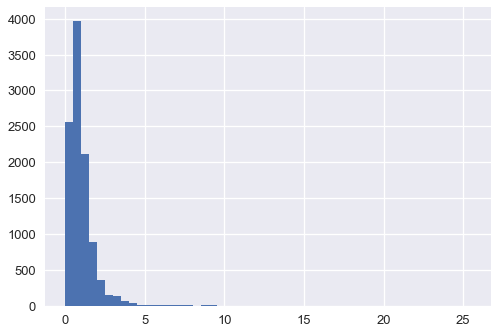

In [278]:
plt.hist(a, bins=[float(x/2) for x in range(52)])

In [266]:
x=list(loaded_features['price'].values())
print(max(x))
print(min(x))

279.99
2.49


(array([ 583.,  806.,  875.,  736.,  819.,  771.,  454.,  535.,  369.,
         515.,  397.,  246.,  352.,  217.,  156.,  251.,  151.,  148.,
         207.,   85.,  134.,   93.,  157.,  103.,   56.,   97.,   63.,
          58.,   97.,   45.,   67.,   88.,   29.,   35.,   34.,   48.,
          23.,   12.,   43.,   22.,   31.,   33.,   10.,   17.,    8.,
          31.,   22.,   13.,   20.,    6.,   10.,   15.,    6.,    8.,
          12.,    5.,   10.,    6.,    6.,    3.,    4.,    6.,    4.,
           3.,    5.,    1.,    5.,    2.,    6.,    1.,    1.,    1.,
           0.,    1.,    2.,    2.,    0.,    4.,    0.,    1.,    1.,
           1.,    1.,    3.,    1.,    4.,    0.,    3.,    1.,    2.,    3.]),
 array([   2.49      ,    5.53945055,    8.5889011 ,   11.63835165,
          14.6878022 ,   17.73725275,   20.7867033 ,   23.83615385,
          26.8856044 ,   29.93505495,   32.98450549,   36.03395604,
          39.08340659,   42.13285714,   45.18230769,   48.23175824,
         

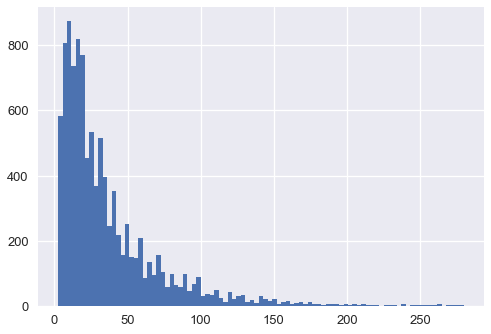

In [268]:

plt.hist(x,bins='auto')

In [274]:
import math
b=[math.log(x) for x in a]

In [275]:
print(max(b))
print(min(b))

2.5606335534562956
-2.88525010777611


In [269]:
y=[math.log(k) for k in x]
print(max(y))
print(min(y))

5.634753888245765
0.9122827104766164


(array([  26.,   85.,   50.,   57.,  120.,   93.,  155.,  181.,  257.,
         124.,  271.,  268.,  515.,  267.,  458.,  428.,  459.,  392.,
         653.,  331.,  524.,  571.,  471.,  377.,  459.,  301.,  432.,
         331.,  331.,  230.,  225.,  237.,  190.,  126.,  100.,   81.,
          59.,   31.,   22.,   11.,   19.]),
 array([ 0.91228271,  1.02746493,  1.14264716,  1.25782938,  1.37301161,
         1.48819383,  1.60337605,  1.71855828,  1.8337405 ,  1.94892273,
         2.06410495,  2.17928717,  2.2944694 ,  2.40965162,  2.52483384,
         2.64001607,  2.75519829,  2.87038052,  2.98556274,  3.10074496,
         3.21592719,  3.33110941,  3.44629164,  3.56147386,  3.67665608,
         3.79183831,  3.90702053,  4.02220275,  4.13738498,  4.2525672 ,
         4.36774943,  4.48293165,  4.59811387,  4.7132961 ,  4.82847832,
         4.94366055,  5.05884277,  5.17402499,  5.28920722,  5.40438944,
         5.51957166,  5.63475389]),
 <a list of 41 Patch objects>)

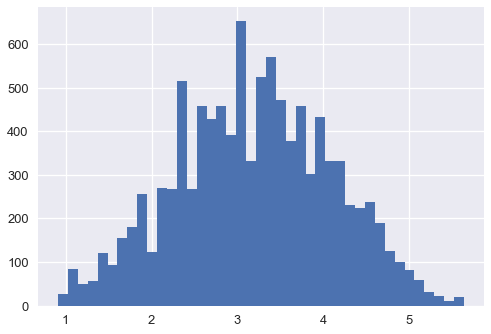

In [270]:
# bins=[x for x in range(1,10)]
plt.hist(y,bins='auto')

(array([  6.52900000e+03,   2.99100000e+03,   5.08000000e+02,
          1.89000000e+02,   4.50000000e+01,   2.20000000e+01,
          1.00000000e+01,   9.00000000e+00,   4.00000000e+00,
          6.00000000e+00,   2.00000000e+00,   1.00000000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Patch objects>)

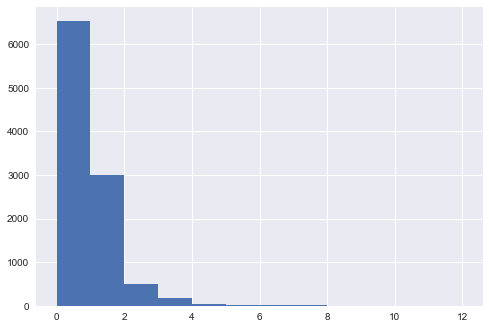

In [89]:
binwidth=1
plt.hist(a, bins=range(int(min(a)), int(max(a)) + binwidth, binwidth))

In [ ]:
"""
When: min_items=4, min_users=0

Then:
max_u_id:  34107
max_i_id:  10318
reviews :  131979
u_id:  10244
i_id:  10318
reviews :  69390
"""

In [ ]:
loaded_features = transform_features(loaded_features)
results = {}

In [281]:
#loaded_features['price_1hotencoded']
#loaded_features['price_log_1hotencoded']
loaded_features.keys()

dict_keys(['brand', 'price', 'feature_vector', 'top_categories', 'level4', 'level4_name', 'average_rating', 'polarity', 'sentiment', 'season', 'price_delta_l4avg', 'level4_average', 'person_l4_budget', 'level4_ratio_price', 'level4_ratio_price_1hotencoded', 'level4_ratio_price_log_1hotencoded', 'brand_1hotencoded', 'price_1hotencoded', 'price_log_1hotencoded', 'level4_average_1hotencoded', 'level4_average_log_1hotencoded'])

In [ ]:
del loaded_features['brand_1hotencoded']

In [ ]:
"""cluster_features = {}
cluster = loaded_features['cluster']
cluster_all = sorted( list(set(cluster.values())) )
for key, value in cluster.items():
    cluster_vec = numpy.zeros(len(cluster_all))
    cluster_vec[int(v)] = 1
    cluster_features[key] = cluster_vec
features['cluster_1hotencoded'] = cluster_features
cluster_all = (list(set( (int(v) for v in cluster.values())) ))"""

In [ ]:
loaded_features['brand']

## Model Running given different variants

In [299]:
# define number of sessions or epochs
NUM_SESSIONS = 10
variants  = {
    'BPR':None,
    #'Cluster':['cluster_1hotencoded']
#     'Price-standard':['price_1hotencoded'],
#     'Price-Log':['price_log_1hotencoded'],
#     'L4-Avg-Price':['level4_average_1hotencoded'],
#      'L4-Ratio':['level4_ratio_price_1hotencoded'],
#      'L4-Ratio-Log':['level4_ratio_price_log_1hotencoded']
#     'L4-Avg-Price-Log':['level4_average_log_1hotencoded']
    #'Price-Adj-10bin':['l4_avg_adjusted_1hotencoded'],
    #'Price-Adj-Log-30bin':['l4_avg_adjusted_log_1hotencoded']
    #'Category-Tags, Subcat-L4, Brand':['top_categories','level4', 'brand_1hotencoded']
    #'Category-Tags':['top_categories'],
    #'Subcat-L4':['level4'],
    #'Price-Log':['price_log_1hotencoded'],
    #'Price-Adj':['l4_avg_adjusted_1hotencoded'],
    #'Price-Adj-Log':['l4_avg_adjusted_log_1hotencoded'],
    #'Brand':['brand_1hotencoded']
}
"""
variants  = {
    #'Price-Log':['price_log_1hotencoded'],
    'Category-Tags, Subcat-L4, $Price':['top_categories','level4','price_log_1hotencoded'],
    'Subcat-L4, Price-Log':['level4','price_log_1hotencoded'],
    'Category-Tags, Price-Log':['top_categories','price_log_1hotencoded'],
    'Category-Tags, Subcat-L4, Brand, Price-Log':['price_log_1hotencoded','top_categories', 'level4', 'brand_1hotencoded']
}
"""

"\nvariants  = {\n    #'Price-Log':['price_log_1hotencoded'],\n    'Category-Tags, Subcat-L4, $Price':['top_categories','level4','price_log_1hotencoded'],\n    'Subcat-L4, Price-Log':['level4','price_log_1hotencoded'],\n    'Category-Tags, Price-Log':['top_categories','price_log_1hotencoded'],\n    'Category-Tags, Subcat-L4, Brand, Price-Log':['price_log_1hotencoded','top_categories', 'level4', 'brand_1hotencoded']\n}\n"

In [300]:
# feature_set() is called without arguments
for desc, features_to_use in variants.items():
    print (desc + str(features_to_use))
    if features_to_use != None:
        features_list = feature_set([loaded_features[c] for c in features_to_use])
    else:
        features_list = feature_set()
    results[desc] = run(NUM_SESSIONS, user_count, item_count, 
                         users, items, user_ratings, 
                         item_ratings,features_list)

BPRNone
epoch  1
train_loss: 0.824610411772 train auc:  0.629851
test_loss:  2.11922527547 test auc:  0.655545
cold start test_loss:  2.16872823105 cold start auc:  0.350912
epoch  2
train_loss: 0.713523556887 train auc:  0.692409
test_loss:  1.59169425514 test auc:  0.669277
cold start test_loss:  1.61599447122 cold start auc:  0.332792
epoch  3
train_loss: 0.662149443335 train auc:  0.710046
test_loss:  1.35164911419 test auc:  0.672681
cold start test_loss:  1.35915306276 cold start auc:  0.330062
epoch  4
train_loss: 0.632108124211 train auc:  0.715529
test_loss:  1.27002687342 test auc:  0.671255
cold start test_loss:  1.28185082771 cold start auc:  0.329752
epoch  5
train_loss: 0.613661324699 train auc:  0.72067
test_loss:  1.27372311158 test auc:  0.671213
cold start test_loss:  1.29042501114 cold start auc:  0.323931
epoch  6
train_loss: 0.603567343425 train auc:  0.727964
test_loss:  1.31688274114 test auc:  0.677802
cold start test_loss:  1.35184872145 cold start auc:  0.3219

In [301]:
plot_list=list(results.keys())
print(plot_list)

['Price-standard', 'Price-Log', 'L4-Ratio', 'L4-Ratio-Log', 'L4-Avg-Price', 'L4-Avg-Price-Log', 'BPR']


In [ ]:
import pickle
datetime.now().strftime("%Y%m%d.%H%M")
pickle.dump( results, open( "results_price_features_k4."+datetime.now().strftime("%Y%m%d.%H%M")
 + ".pickle", "wb" ) ) 

## Single Features

In [302]:
#single_features = ['BPR','Category-Tags','Subcat-L4','Price-Log','Price-Adj-Log','Brand']
#results_to_graph ={v:results[v] for v in single_features}
single_features = plot_list
#'Price-10bin', 'Price-Log-30bin', 'L4-Avg-10bin', 'Price-Adj-10bin', 'Price-Adj-Log-30bin']
results_to_graph ={v:results[v] for v in single_features}

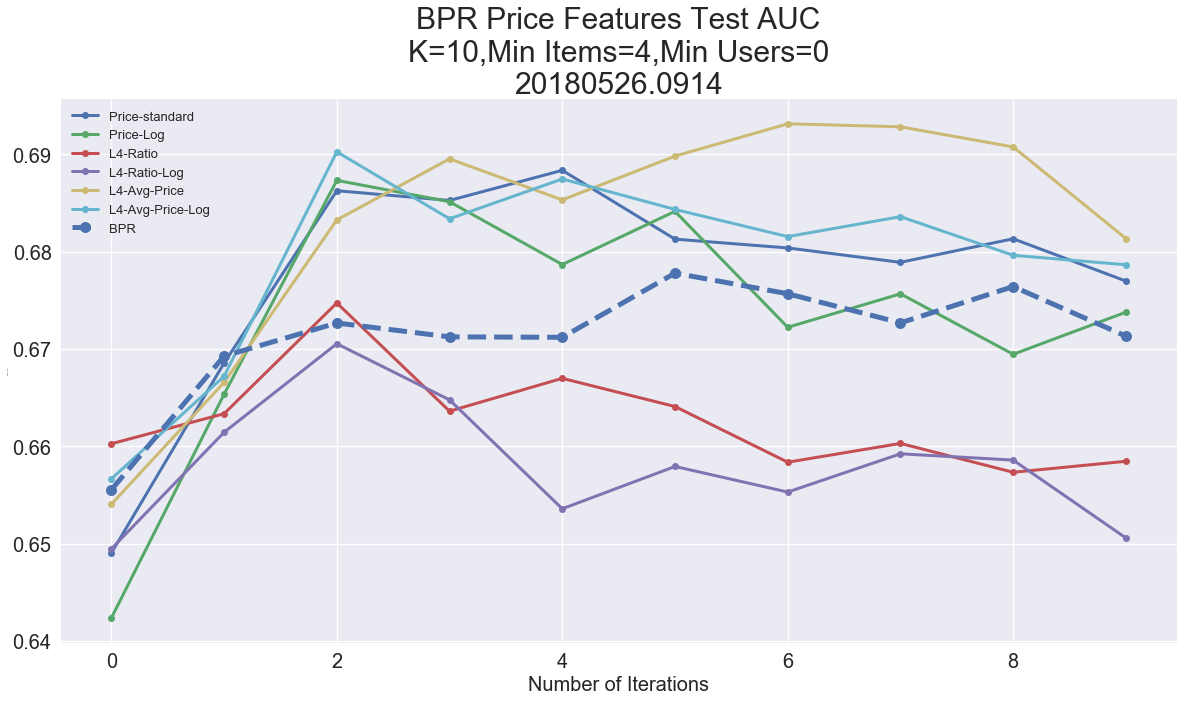

In [318]:
rpt_date = datetime.now().strftime("%Y%m%d.%H%M")
plot_auc_curve(results_to_graph,'BPR Price Features Test AUC\nK=10,Min Items=4,Min Users=0\n' + rpt_date ,None)

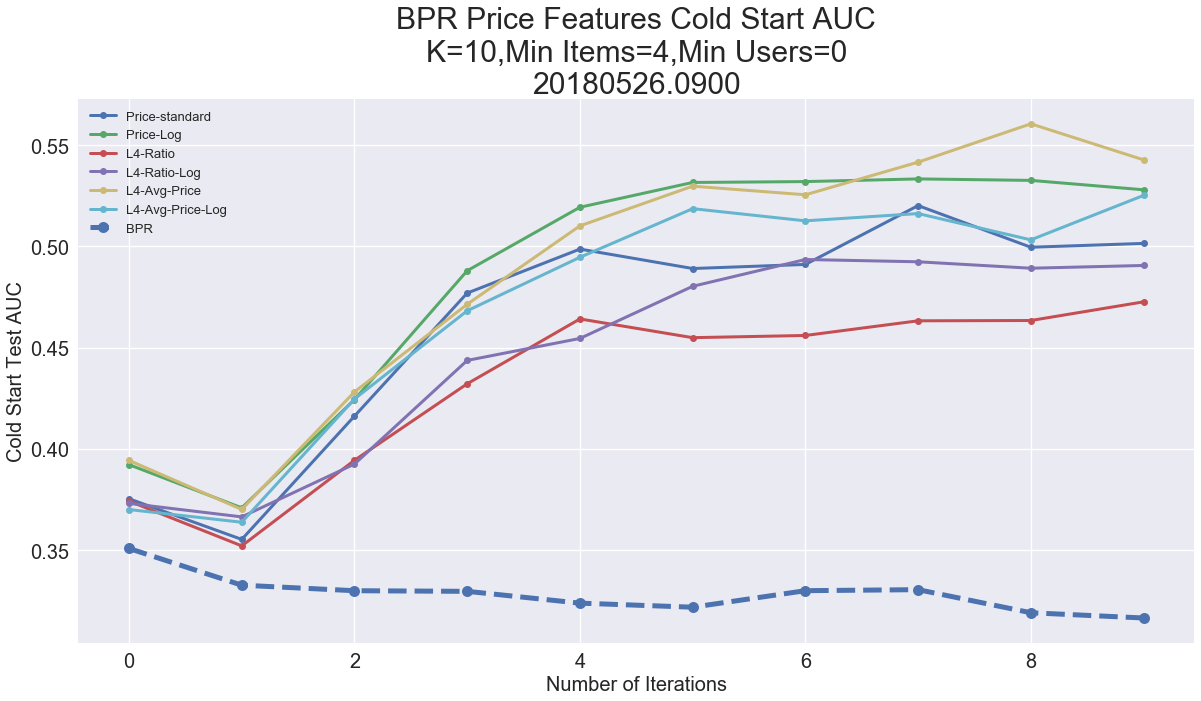

In [304]:
plot_auc_cold_start_curve(results, 'BPR Price Features Cold Start AUC\nK=10,Min Items=4,Min Users=0\n' + rpt_date,None)

### Run Feature Combinations: Comparing to BPR and Category-Tags

In [ ]:
combos = ['BPR','Category-Tags', 'Category-Tags, Subcat-L4, Brand']
results_to_graph ={v:results[v] for v in combos}
plot_auc_curve(results_to_graph,
               'BPR Test AUC\nCategory Tags vs Feature Combinations\nK=10,Min Items=4,Min Users=0\n' + rpt_date,
               'Category-Tags')

In [ ]:
plot_auc_cold_start_curve(results_to_graph,
                          'BPR Cold Start Test AUC\nCategory Tags vs Feature Combinations\nK=10,Min Items=4,Min Users=0\n' + rpt_date,
                          'Category-Tags')

### Attempt to capture performance characteristics; wasn't meaningful

In [ ]:
import pickle
results_0141 = pickle.load( open( "results.20180511.0141.pickle", "rb" ) )

In [ ]:
z = [v['delta_sec'] for k,v in results.items()]

In [ ]:
dt_str = datetime.now().strftime("%Y%m%d.%H%M")
sns.set_context("talk")
plt.figure(figsize=(20,10))
plt.tick_params(axis='both', which='major', labelsize=20)
#plt.title(title,fontsize=30)
plt.scatter(z,
    #label=calc_desc,
    #linewidth=lw,
    #linestyle=ls,
    #markersize=ms,
    marker='o')
plt.legend()
#plt.ylabel("Cold Start Test AUC",fontsize=20)
#plt.xlabel("Number of Iterations",fontsize=20)

### Simple output of AUC value from last iteration

In [ ]:
for k,v in results.items():   
    print('AUC Test -' + k +  str(v['auc_test'][-1]))
    print('Cold Start AUC Test - '+ k + str(v['auc_cold_test'][-1]))    

In [ ]:
## FOR NOLAN TO ADD
user_items_test = results['Category-Tags, Subcat-L4, Brand']['user_items_test']
#def build_recommendation_list(users, items, user_items_test):
f = {}    
for i in (x[0]for x in enumerate(user_items_test)):
    for x in zip(user_items_test[i][0], user_items_test[i][1]):
        f[(x[0][0], x[0][1], x[0][2])] = x[1][0]

user_item_rec_score = {}
user_item_pur_score= {}
for x in list(f.keys()):
    # if SCORE is less than zero meaning USER preffered j Over i
    if f[x] < 0:
        if x[0] not in user_item_rec_score.keys():
            user_item_rec_score[x[0]] = []
        user_item_rec_score[x[0]].append((x[2], f[x]))
    # SCORE of more than 0, meaning user preffered i over j
    else:
        if x[0] not in user_item_pur_score.keys():
            user_item_pur_score[x[0]] = []
        user_item_pur_score[x[0]].append((x[1], f[x]))

#reverse dict for look up
users_lookup= {v:k for k,v in users.items()}
items_lookup= {v:k for k,v in items.items()}

array=[]
for x in list(user_item_rec_score.keys()):
    try:
        a=user_item_rec_score[x]
        b= sorted(a, key=lambda x: x[1])
        #old loop: for i in range(10): 
        #recommending up to top 10 items
        for i in range( len(b) ): #min((len(b), 10)) ):
                array.append((users_lookup[x], items_lookup[b[i][0]]))  
    except IndexError:
        raise IndexError("Index Error at x,i",x,i)


#create dataframe of user and their REC LIST- Top 10 SORTED by high to low Preference score so ORDER matters
df=pd.DataFrame(array, columns=['User','Recommended Items'])
df_Rec=df.groupby('User', as_index=False)['Recommended Items'].agg({'Recommendation list':(lambda x: list(x))})

c=df_Rec.set_index('User').T.to_json()

import json as json
#user_items_test = rz['Category-Tags']['user_items_test']
#rec_json = build_recommendation_list(users, items, user_items_test)

In [ ]:
df_Rec.head()

In [ ]:
print (rec_df.shape, len(user_items_test), len(users), len(items))
df_row =  df_Rec.iloc[574]
print (df_row['User'], df_row['Recommendation list'])

with open('reclist_json', 'w+') as f: 
    f.write(json.dumps(c))

In [ ]:

#!ls *.pickle
import pickle
results = pickle.load( open( "results_k10_minitem1_minuser1.20180521.2306.pickle", "rb" ) )
results['Price-Log'] = results['Price-Log_10']
del results['Price-Log_10']
results.keys()
rpt_date = datetime.now().strftime("%Y%m%d.%H%M")

In [ ]:
plot_auc_curve(results,
               'BPR Test AUC\nK=10,Min Items=1,Min Users=1\n' + rpt_date,
               'Category-Tags')
plot_auc_cold_start_curve(results,
               'BPR Cold Test AUC\nK=10,Min Items=1,Min Users=1\n' + rpt_date,
               'Category-Tags')

### Trying with dimension of 0

In [6]:
bpr_data_file = os.path.join(home, 'data', 'out_model_features.20180523.tab.csv')
data_path = os.path.join(bpr_data_file)
user_count, item_count, users, items, user_ratings, item_ratings, loaded_features   = load_data_hybrid(data_path, 
                                                                                                       min_items=4, 
                                                                                                       min_users=0)

max_u_id:  34107
max_i_id:  10318
reviews :  131979
u_id:  10244
i_id:  10318
reviews :  69390


In [25]:
loaded_features.keys()

dict_keys(['brand', 'price', 'feature_vector', 'top_categories', 'level4', 'level4_name', 'average_rating', 'polarity', 'sentiment', 'season', 'price_delta_l4avg', 'level4_average', 'person_l4_budget', 'level4_ratio_price'])

In [7]:
loaded_features = transform_features(loaded_features)
results = {}

In [8]:
features_list = feature_set()

In [10]:
results['BPR-Dim-0'] = run(10, user_count, item_count, 
                         users, items, user_ratings, 
                         item_ratings,features_list,0,0)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch  1
train_loss: 0.671778135691 train auc:  0.621363
test_loss:  0.706571063221 test auc:  0.658552
cold start test_loss:  0.741585192585 cold start auc:  0.353217
epoch  2
train_loss: 0.637102647065 train auc:  0.692098
test_loss:  0.794544889614 test auc:  0.662359
cold start test_loss:  0.817138470716 cold start auc:  0.329561
epoch  3
train_loss: 0.616639993128 train auc:  0.71184
test_loss:  0.904474391162 test auc:  0.670017
cold start test_loss:  0.90652992384 cold start auc:  0.328853
epoch  4
train_loss: 0.60469803402 train auc:  0.71763
test_loss:  1.00409018187 test auc:  0.669105
cold start test_loss:  1.00914283744 cold start auc:  0.325812
epoch  5
train_loss: 0.598564001472 train auc:  0.720917
test_loss:  1.085338957 test auc:  0.672307
cold start test_loss:  1.11387647921 cold start auc:  0.323861
epoch  6
train_loss: 0.596207644844 train auc:  0.724013
test_loss:  1.16855464303 test auc:  0.6

NameError: name 'NUM_SESSIONS' is not defined